# DSPy - Advanced Prompt Engineering

1. Breakout Room #1:
  - Task 1: Dependencies
  - Task 2: Loading Our Model
  - Task 3: Loading Our Data
  - Task 4: Setting Our Signature
  - Task 5: Creating a Predictor
  - Task 6: Making a Chain, I mean...Module
  - Task 7: Evaluate
  - Task 8: Program Optimization
2. Breakout Room #2:
  - Task 1: Defining Appliation
  - Task 2: Hyper-Parameters and Data
  - Task 3: Signature And Module Creation
  - Task 4: Evaluating Our LongFormQA Module
  - Task 5: Adding Assertions

---

In the following notebook, we'll explore an introduction to DSPy and what it can do in just a few lines of code!

# 🤝 Breakout Room #1

## Task 1: Dependencies

We'll start by installing DSPy, `nltk` (for later) and including our OpenAI API key.

In [110]:
!pip install -qU dspy-ai nltk

DSPy can leverage OpenAI's models under the hood, and still provide an advantage - in order to do so, however, we'll need to provide an OpenAI API Key!

In [111]:
import os
import getpass

os.environ['OPENAI_API_KEY'] = getpass.getpass('OpenAI API Key: ')

## Task 2: Loading Our Model

Now we can setup our OpenAI language model - which we'll use through the remaining cells in the notebook.

In [112]:
from dspy import LM

llm = LM(model='openai/gpt-3.5-turbo')

Similar to other libraries, we can call the LLM directly with a string to get a response!

In [113]:
llm("What is the square root of pi?")

['The square root of pi is approximately 1.77245385091.']

We'll also set our `setting.configure` with our OpenAI model in the `lm` (Language Model) field for a default LM to use in case we don't specify which LM we'd like to use when calling our DSPy `Predictors`.

In [114]:
import dspy

dspy.settings.configure(lm=llm)

## Task 3: Load Our Data

We're going to be using a dataset that provides a number of example sentences, along with a rating that indicates their "dopeness" level.

In [115]:
from datasets import load_dataset

dataset = load_dataset("llm-wizard/dope_or_nope_v2")

We have a total of 99 rows of data, and will be splitting that into a `trainset` and a `valset` - for training and evaluation.

In [116]:
dataset

DatasetDict({
    train: Dataset({
        features: ['Sentence', 'Rating', 'Fire Emojis'],
        num_rows: 99
    })
})

Due to the nature of the dataset, we'll need to shuffle our dataset to ensure our labels are not clumped up, and our `valset` is remotely representative to our `trainset`.

In [117]:
dataset = dataset.shuffle(seed=42)

We'll move our `Dataset` into the expected format in DSPy which is the [`Example`](https://dspy-docs.vercel.app/docs/deep-dive/data-handling/examples)!


Our examples will have two keys:

- `sentence`, our input sentence to be rated
- `rating`, our rating label

We'll specify our input as `sentence` to properly leverage the DSPy framework.

In [118]:
from dspy import Example

trainset = []

for row in dataset["train"].select(range(0,len(dataset["train"])-10)):
  trainset.append(Example(sentence=row["Sentence"], rating=row["Rating"]).with_inputs("sentence"))

len(trainset)

89

We'll repeat the same process for our `valset` as well.

In [119]:
valset = []

for row in dataset["train"].select(range(len(trainset),len(dataset["train"]))):
  valset.append(Example(sentence=row["Sentence"], rating=row["Rating"]).with_inputs("sentence"))

len(valset)

10

Let's take a peek at an example from our `trainset` and `valset`!

In [120]:
train_example = trainset[0]
print(f"Sentence: {train_example.sentence}")
print(f"Label: {train_example.rating}")

Sentence: The results were satisfactory.
Label: 0


In [121]:
valset_example = valset[0]
print(f"Sentence: {valset_example.sentence}")
print(f"Label: {valset_example.rating}")

Sentence: This is top tier.
Label: 4


## Task 4: Setting Our Signature

The first foundational unit in DSPy is the `Signature`.

In a sense, a `Signature` can be thought of as both a prompt, as well as metadata about that prompt.

Going beyond just a simple `SystemMessage`, as seen in other frameworks, the `Signature` helps DSPy validate datatypes, create examples, and more.

> NOTE: DSPy's [documentation](https://dspy-docs.vercel.app/docs/deep-dive/signature/understanding-signatures#what-is-a-signature) goes into more detail about what exactly a `Signature` is.

In [122]:
from dspy import Signature, InputField, OutputField

class DopeOrNopeSignature(Signature):
  """Rate a sentence from 0 to 4 on a dopeness scale"""
  sentence: str = InputField()
  rating: int = OutputField()

## Task 5: Creating a Predictor

Now that we have our `Signature`, we can build a `Predictor` that leverages it.

A `Predictor`, in the simplest terms, is what calls the LLM using our signature. Importantly, the `Predictor` knows how to leverage our signature to call the LLM. From DSPy's documentation, one of the most interesting parts of a `Predictor` is that it can *learn* to become better at the desired task!

Let's take a look at our `TypedPredictor` below to see more.

In [123]:
from dspy.functional import TypedPredictor

generate_label = TypedPredictor(DopeOrNopeSignature)

In [124]:
generate_label

TypedPredictor(DopeOrNopeSignature(sentence -> rating
    instructions='Rate a sentence from 0 to 4 on a dopeness scale'
    sentence = Field(annotation=str required=True json_schema_extra={'__dspy_field_type': 'input', 'prefix': 'Sentence:', 'desc': '${sentence}'})
    rating = Field(annotation=int required=True json_schema_extra={'__dspy_field_type': 'output', 'prefix': 'Rating:', 'desc': '${rating}'})
))

In [125]:
label_prediction = generate_label(sentence=valset_example.sentence)
print(f"Sentence: {valset_example.sentence}")
print(f"Prediction: {label_prediction}")

Sentence: This is top tier.
Prediction: Prediction(
    rating=4
)


We can, at any time, check our LLMs outputs through the `inspect_history`.

In [126]:
llm.inspect_history(n=1)





System message:

Your input fields are:
1. `sentence` (str)

Your output fields are:
1. `rating` (int): ${rating} (Respond with a single int value)

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## sentence ## ]]
{sentence}

[[ ## rating ## ]]
{rating}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        Rate a sentence from 0 to 4 on a dopeness scale


User message:

[[ ## sentence ## ]]
This is top tier.

Respond with the corresponding output fields, starting with the field `rating`, and then ending with the marker for `completed`.


Response:

[[ ## rating ## ]]
4
[[ ## completed ## ]]







Notice how, without our input - the `TypedPredictor` has included format instructions to the LLM to help ensure our returned data resembles what we desire.

Let's look at another example of a `Predictor` - this time with Chain of Thought.

In order to use this - we don't have to do anything with our `Signature`! We can leave it exactly as is - and allow the `Predictor` to adapt to it.

> NOTE: We won't be using this predictor going forward - this is just to showcase the ease of using another `Predictor` with a `Signature`.

In [127]:
from dspy.functional import TypedChainOfThought

generate_label_with_chain_of_thought = TypedChainOfThought(DopeOrNopeSignature)

label_prediction = generate_label_with_chain_of_thought(sentence=valset_example.sentence)

In [128]:
print(f"Sentence: {valset_example.sentence}")
print(f"Reasoning: {label_prediction.reasoning}")
print(f"Ground Truth Label: {valset_example.rating}")
print(f"Prediction: {label_prediction.rating}")

Sentence: This is top tier.
Reasoning: I would rate this sentence as a 4 because it conveys a high level of excellence or superiority.
Ground Truth Label: 4
Prediction: 4


We can, again, check our LLM's history to see what the actual prompt/response is.


In [129]:
llm.inspect_history(n=1)





System message:

Your input fields are:
1. `sentence` (str)

Your output fields are:
1. `reasoning` (str): ${produce the rating}. We ...
2. `rating` (int): ${rating} (Respond with a single int value)

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## sentence ## ]]
{sentence}

[[ ## reasoning ## ]]
{reasoning}

[[ ## rating ## ]]
{rating}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        Rate a sentence from 0 to 4 on a dopeness scale


User message:

[[ ## sentence ## ]]
This is top tier.

Respond with the corresponding output fields, starting with the field `reasoning`, then `rating`, and then ending with the marker for `completed`.


Response:

[[ ## reasoning ## ]]
I would rate this sentence as a 4 because it conveys a high level of excellence or superiority. 

[[ ## rating ## ]]
4

[[ ## completed ## ]]







## Task 6: Making a Chain, I mean...Module.

Now that we have our `TypedPredictor`, we can create a `Module`!

A `Module` is useful because it allows us to interact with the `Predictor` and `Signature` in a way that DSPy can leverage for optimization.

The helps the DSPy framework determine paths through your program - and helps during the `compilation` or optimisation steps (formerly `teleprompting`).

> NOTE: You might notice this looks strikingly familiar to PyTorch, and this is by design!

In [130]:
from dspy import Module, Prediction

class DopeOrNopeStudent(Module):
  def __init__(self):
    super().__init__()

    self.generate_rating = TypedPredictor(DopeOrNopeSignature)

  def forward(self, sentence):
    prediction = self.generate_rating(sentence=sentence)
    return Prediction(rating=prediction.rating)

## Task 7: Evaluate

As with any good framework, DSPy has the ability to `Evaluate` - we can leverage this to determine how our current DSPy "program" (our `Module` in this case) operates.

> NOTE: DSPy's "program" could be loosely related to a "chain" from the popular LLM Framework LangChain.

In [131]:
from dspy.evaluate.evaluate import Evaluate

evaluate_fewshot = Evaluate(devset=valset, num_threads=1, display_progress=True, display_table=10)

def exact_match_metric(answer, pred, trace=None):
  return answer.rating == pred.rating

evaluate_fewshot(DopeOrNopeStudent(), metric=exact_match_metric)

Average Metric: 4 / 10  (40.0): 100%|██████████| 10/10 [00:00<00:00, 1014.17it/s]


,sentence,example_rating,pred_rating,exact_match_metric
0,This is top tier.,4,4,✔️ [True]
1,Big mood.,3,3,✔️ [True]
2,The presentation was outstanding.,1,4,
3,I'm living my best life.,4,3,
4,"Sksksksk, that's hilarious.",3,2,
5,The report is comprehensive.,1,3,
6,This is next level.,4,4,✔️ [True]
7,The meeting was productive.,1,3,
8,The analysis was insightful.,1,3,
9,I stan a legend.,3,3,✔️ [True]


40.0

#### ❓Question #1:

Does DSPy lend itself to more complex less exactly defined evaluations? Provide reasoning for your answer.

ANSWER:

Yes, DSPy is well-suited for complex, less defined evaluations because:

1.	Flexible Data Handling: It can process and analyze messy or unclear data, making it ideal for real-world situations.
2.	Variety of Models: DSPy supports machine learning and statistical models that handle uncertainty and non-exact outcomes.
3.	Exploratory Tools: It offers tools for discovering patterns and insights even when the criteria aren’t clear.
4.	Advanced Techniques: DSPy includes methods like simulations and probabilistic models that are designed for complex decision-making.

DSPy flexibility and advanced tools make it great for handling less precise evaluations.

## Task 8: Program Optimization (the Artist Formerly Known as Teleprompting)

Optimization is the crux of the DSPy framework - it is what allows it to operate at a level beyond traditional prompt engineering.

At a high level, optimisation is a way for the DSPy framework to take the program, a training set, and a metric - and make changes/tweaks to our program to improve our metrics on our dataset.

Let's get started with the `LabeledFewShot` optimizer.

The `LabeledFewShot` optimizer very simply provides a sample of the `trainset` as few-shot examples!

In [132]:
from dspy.teleprompt import LabeledFewShot

labeled_fewshot_optimizer = LabeledFewShot(k=4)

Once we define our optimizer, we can compile our program!

In [133]:
compiled_dspy = labeled_fewshot_optimizer.compile(student=DopeOrNopeStudent(), trainset=trainset)

Let's evaluate!

In [134]:
evaluate_fewshot(compiled_dspy, metric=exact_match_metric)

Average Metric: 4 / 10  (40.0): 100%|██████████| 10/10 [00:00<00:00, 1039.17it/s]


,sentence,example_rating,pred_rating,exact_match_metric
0,This is top tier.,4,4,✔️ [True]
1,Big mood.,3,3,✔️ [True]
2,The presentation was outstanding.,1,3,
3,I'm living my best life.,4,3,
4,"Sksksksk, that's hilarious.",3,3,✔️ [True]
5,The report is comprehensive.,1,2,
6,This is next level.,4,3,
7,The meeting was productive.,1,3,
8,The analysis was insightful.,1,3,
9,I stan a legend.,3,3,✔️ [True]


40.0

As you can see - with no effort at all - we can improve our performance on our `valset`!

Let's try another optimizer - this time: [`BootstrapFewShot`](https://dspy-docs.vercel.app/docs/deep-dive/teleprompter/bootstrap-fewshot).

The key thing to note is that this optimizer works with even very few examples - by way of generating new examples by the LLMs!

In [135]:
from dspy.teleprompt import BootstrapFewShot

optimizer = BootstrapFewShot(metric=exact_match_metric, max_bootstrapped_demos=4, max_labeled_demos=12)

compiled_dspy_BOOTSTRAP = optimizer.compile(student=DopeOrNopeStudent(), trainset=trainset)

  6%|▌         | 5/89 [00:00<00:00, 1301.77it/s]

Bootstrapped 4 full traces after 6 examples in round 0.


#### 🏗️ Activity #1:

Outline how `BootstrapFewShot` works "under the hood" in natural language or create a diagram of the workflow.

ANSWER:

1. Initial Training (Bootstrap Stage): The process begins with a few-shot learning setup, where the model is trained on a small labeled dataset. This provides the model with initial knowledge, but performance is limited due to the small amount of training data. The few-shot examples act as the starting point for the bootstrap process.

2. Predict on Unlabeled Data (Few-Shot Generalization): After initial training, the model is applied to a large, unlabeled dataset to generate predictions. The model uses the few-shot examples to generalize and predict labels for the new data. Confidence scores are generated for each prediction, indicating the model’s certainty.

3. Confidence-Based Filtering (Select High-Confidence Predictions): The model’s predictions are filtered based on confidence, and only high-confidence predictions are kept. These predictions become pseudo-labels, acting as approximations of the true labels. The idea is that confident predictions are accurate enough to be useful for further training.

4. Augment Dataset (Dataset Expansion): The pseudo-labeled data is added to the original few-shot dataset, expanding the training set. The model is then retrained on this augmented dataset, allowing it to improve its generalization capabilities with more data.

5. Iterative Process (Refinement through Feedback Loops): This process is repeated iteratively: the model generates new predictions, filters them by confidence, and retrains on the updated dataset. With each cycle, the model’s predictions improve, and the pseudo-labels become more reliable, leading to better overall performance.

6. Convergence (Model Performance Stabilization): After several iterations, the model’s performance stabilizes as it has learned from a much larger training set (few-shot data plus pseudo-labeled data). The final model is more robust and accurate than the initial version, thanks to the iterative bootstrap process.



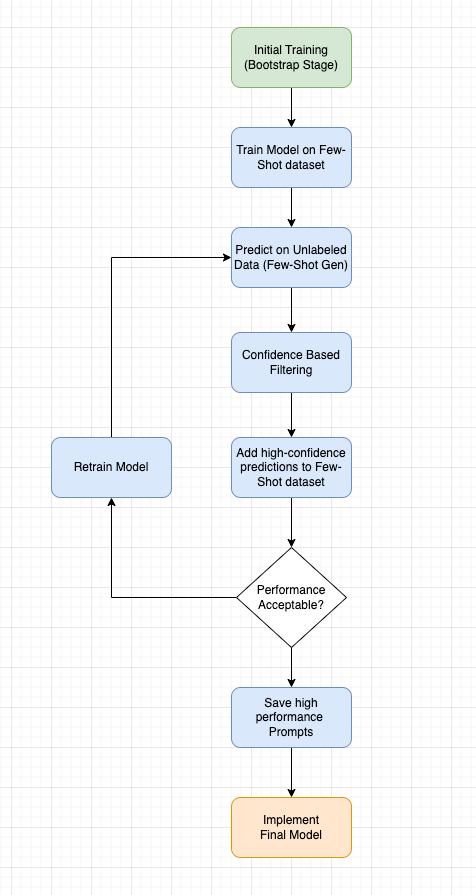




Let's finally evaluate!

In [136]:
evaluate_fewshot(compiled_dspy_BOOTSTRAP, metric=exact_match_metric)

Average Metric: 8 / 10  (80.0): 100%|██████████| 10/10 [00:00<00:00, 989.41it/s]


,sentence,example_rating,pred_rating,exact_match_metric
0,This is top tier.,4,4,✔️ [True]
1,Big mood.,3,3,✔️ [True]
2,The presentation was outstanding.,1,3,
3,I'm living my best life.,4,4,✔️ [True]
4,"Sksksksk, that's hilarious.",3,3,✔️ [True]
5,The report is comprehensive.,1,1,✔️ [True]
6,This is next level.,4,4,✔️ [True]
7,The meeting was productive.,1,1,✔️ [True]
8,The analysis was insightful.,1,2,
9,I stan a legend.,3,3,✔️ [True]


80.0

We can see that this optimization helps our program achieve 30 points higher on our evaluation!

In [137]:
llm.inspect_history(n=1)





System message:

Your input fields are:
1. `sentence` (str)

Your output fields are:
1. `rating` (int): ${rating} (Respond with a single int value)

All interactions will be structured in the following way, with the appropriate values filled in.

[[ ## sentence ## ]]
{sentence}

[[ ## rating ## ]]
{rating}

[[ ## completed ## ]]

In adhering to this structure, your objective is: 
        Rate a sentence from 0 to 4 on a dopeness scale


User message:

[[ ## sentence ## ]]
This tea is piping hot.

Respond with the corresponding output fields, starting with the field `rating`, and then ending with the marker for `completed`.


Assistant message:

[[ ## rating ## ]]
4

[[ ## completed ## ]]


User message:

[[ ## sentence ## ]]
Your professionalism is appreciated.

Respond with the corresponding output fields, starting with the field `rating`, and then ending with the marker for `completed`.


Assistant message:

[[ ## rating ## ]]
1

[[ ## completed ## ]]


User message:

[[ ## sente

In [138]:
for name, parameter in compiled_dspy_BOOTSTRAP.named_parameters():
  print(f"Parameter {name}: Num Examples: {len(parameter.demos)}, {parameter.demos[0]}")
  print()

Parameter generate_rating.predictor: Num Examples: 12, Example({'augmented': True, 'sentence': 'This tea is piping hot.', 'rating': '4'}) (input_keys=None)



# 🤝 Breakout Room #2

## Task 1: Defining Application

In this breakoutroom, we'll be using DSPy to optimize a Multi-Hop QA module with `Assertions`.

So what is a "Multi-Hop QA module"?

Well - going beyond naive RAG retrieval, Multi-Hop QA lets us create applications that are well-suited to questions that (potentially have) multiple "hops" required to answer them.

For instance: "Who is the top goal scorer that has ever played on the Winnipeg Jets, and what years did he play for the Winnipeg Jets?"

You can see that there are two "hops" required to respond correctly:

1. Who is the top goal scorer for the Winnipeg Jets?
2. What years did X player play for the Winnipeg Jets?

While this is a toy example, the idea is the same across complexity: Questions that take more than one step of reasoning to answer.

Let's grab some data, set-up some hyper-parameters, and then get to implmentation!

## Task 2: Hyper-Parameters and Data

We'll use the DSPy ColBERT abstracts as our retrieval system for this example.

We'll also use `GPT-4o-Mini` as our LM to keep things light and inexpensive as we'll be sending quite a few LLM calls.

In [139]:
colbertv2_wiki17_abstracts = dspy.ColBERTv2(url='http://20.102.90.50:2017/wiki17_abstracts')
dspy.settings.configure(rm=colbertv2_wiki17_abstracts)
lm_openai_four_mini = dspy.LM(model='openai/gpt-4o-mini', max_tokens=500)
dspy.settings.configure(lm=lm_openai_four_mini, trace=[], temperature=0.7)

We'll be using the [`HotPotQA`](https://hotpotqa.github.io/) dataset which is a number of multi-hop QA pairs that includes context, and is based on Wikipedia (for compatibility with our Retriever system).

In [140]:
from dspy.datasets import HotPotQA

dataset = HotPotQA(train_seed=1, train_size=20, eval_seed=2023, dev_size=50, test_size=0, keep_details=True)
trainset = [x.with_inputs('question') for x in dataset.train]
devset = [x.with_inputs('question') for x in dataset.dev]

Average Metric: 3.0 / 13  (23.1):  52%|█████▏    | 13/25 [13:10<12:09, 60.83s/it] 


We can look at a few examples:

In [141]:
train_example = trainset[0]
print(f"Question: {train_example.question}")
print(f"Answer: {train_example.answer}")
print(f"Relevant Wikipedia Titles: {train_example.gold_titles}")

Question: At My Window was released by which American singer-songwriter?
Answer: John Townes Van Zandt
Relevant Wikipedia Titles: {'At My Window (album)', 'Townes Van Zandt'}


In [142]:
dev_example = devset[18]
print(f"Question: {dev_example.question}")
print(f"Answer: {dev_example.answer}")
print(f"Relevant Wikipedia Titles: {dev_example.gold_titles}")

Question: What is the nationality of the chef and restaurateur featured in Restaurant: Impossible?
Answer: English
Relevant Wikipedia Titles: {'Restaurant: Impossible', 'Robert Irvine'}


## Task 3: Signature and Module Creation

As we learned above - the bread and butter for DSPy is the `Signature` and `Module`, so we'll create each below.

For our `Signatures`, things are fairly straight-forward, we need to:

1. Create a `Signature` that will allow us to generate sub-questions.
2. Create a `Signature` that will provide citations for our responses.

In [143]:
from dsp.utils import deduplicate

class GenerateSearchQuery(dspy.Signature):
    """Write a simple search query that will help answer a complex question."""
    context = dspy.InputField(desc="may contain relevant facts")
    question = dspy.InputField()
    query = dspy.OutputField()

class GenerateCitedParagraph(dspy.Signature):
    """Generate a paragraph with citations."""
    context = dspy.InputField(desc="may contain relevant facts")
    question = dspy.InputField()
    paragraph = dspy.OutputField(desc="includes citations")

Our `Module` is a bit more complex than what we've seen before - so let's walk through what's happening inside of it. We're going to concern ourselves with the `forward` method - as that is where the logic of our `Module` is contained.

In the `forward` method we:

1. Create an empty list of contexts.
2. For each `hop` in our `max_hops` (by default, it will be 2) we:
  - Generate a new `query` using our `GenerateSearchQuery` with a `ChainOfThought` predictor.
  - Retrieve a number (default 3) of `passages` based on that new `query`.
  - Add unique (non-present) `passages` into our `context` list.
3. Take all that `context` and our original `question` and generate a cited paragraph and use it to predict an answer.

In [144]:
class LongFormQA(dspy.Module):
    def __init__(self, passages_per_hop=3, max_hops=2):
        super().__init__()
        self.generate_query = [dspy.ChainOfThought(GenerateSearchQuery) for _ in range(max_hops)]
        self.retrieve = dspy.Retrieve(k=passages_per_hop)
        self.generate_cited_paragraph = dspy.ChainOfThought(GenerateCitedParagraph)
        self.max_hops = max_hops

    def forward(self, question):
        context = []
        for hop in range(self.max_hops):
            query = self.generate_query[hop](context=context, question=question).query
            passages = self.retrieve(query).passages
            context = deduplicate(context + passages)
        pred = self.generate_cited_paragraph(context=context, question=question)
        pred = dspy.Prediction(context=context, paragraph=pred.paragraph)
        return pred

Next, we'll need a way to evaluate how we're doing!

## Task 4: Evaluating our LongFormQA Module.

Now we'd like to evaluate our module - we'll need a number of helper functions to do so - which will be instantiated below.

#### Utility Functions for Citation Checking

In [175]:
import nltk
import regex as re

from nltk.tokenize import sent_tokenize
nltk.download('punkt_tab')

def extract_text_by_citation(paragraph):
    citation_regex = re.compile(r'(.*?)(\[\d+\]\.)', re.DOTALL)
    parts_with_citation = citation_regex.findall(paragraph)
    citation_dict = {}
    for part, citation in parts_with_citation:
        part = part.strip()
        citation_num = re.search(r'\[(\d+)\]\.', citation).group(1)
        citation_dict.setdefault(str(int(citation_num) - 1), []).append(part)
    return citation_dict

def correct_citation_format(paragraph):
    modified_sentences = []
    sentences = sent_tokenize(paragraph)
    for sentence in sentences:
        modified_sentences.append(sentence)
    citation_regex = re.compile(r'\[\d+\]\.')
    i = 0
    if len(modified_sentences) == 1:
      has_citation = bool(citation_regex.search(modified_sentences[i]))
    while i < len(modified_sentences):
      if len(modified_sentences[i:i+2]) == 2:
        sentence_group = " ".join(modified_sentences[i:i+2])
        has_citation = bool(citation_regex.search(sentence_group))
        if not has_citation:
            return False
        i += 2 if has_citation and i+1 < len(modified_sentences) and citation_regex.search(modified_sentences[i+1]) else 1
      else:
        return True
    return True

def has_citations(paragraph):
    return bool(re.search(r'\[\d+\]\.', paragraph))

def citations_check(paragraph):
    return has_citations(paragraph) and correct_citation_format(paragraph)

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/danielgutierrez/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


### Checking Citation Faithfulness

We will create a number of useful metrics for our pipeline - included "Faithfulness", as well as a number of more traditional metrics. "

In [146]:
class CheckCitationFaithfulness(dspy.Signature):
    """Verify that the text is based on the provided context."""
    context = dspy.InputField(desc="may contain relevant facts")
    text = dspy.InputField(desc="between 1 to 2 sentences")
    faithfulness = dspy.OutputField(desc="boolean indicating if text is faithful to context")

def citation_faithfulness(example, pred, trace):
    paragraph, context = pred.paragraph, pred.context
    citation_dict = extract_text_by_citation(paragraph)
    if not citation_dict:
        return False, None
    context_dict = {str(i): context[i].split(' | ')[1] for i in range(len(context))}
    faithfulness_results = []
    unfaithful_citations = []
    check_citation_faithfulness = dspy.ChainOfThought(CheckCitationFaithfulness)
    for citation_num, texts in citation_dict.items():
        if citation_num not in context_dict:
            continue
        current_context = context_dict[citation_num]
        for text in texts:
            try:
                result = check_citation_faithfulness(context=current_context, text=text)
                is_faithful = result.faithfulness.lower() == 'true'
                faithfulness_results.append(is_faithful)
                if not is_faithful:
                    unfaithful_citations.append({'paragraph': paragraph, 'text': text, 'context': current_context})
            except ValueError as e:
                faithfulness_results.append(False)
                unfaithful_citations.append({'paragraph': paragraph, 'text': text, 'error': str(e)})
    final_faithfulness = all(faithfulness_results)
    if not faithfulness_results:
        return False, None
    return final_faithfulness, unfaithful_citations

#### ❓Question #2:

How is faithfulness being determined here? How is this different from Ragas Faithfulness.

ANSWER:

Faithfulness is determined by comparing a citation or quote to its relevant context to check if it accurately reflects the content. Here’s the process:

1.	Citation Extraction: Extract citations from the paragraph.
2.	Context Matching: Match each citation with the relevant input context.
3.	Faithfulness Check: Verify if each citation is faithful to its context by ensuring it doesn’t distort the facts.

The result is a boolean value that indicates whether the citation is faithful, with unfaithful ones flagged if found.

Difference from RAG’s Faithfulness:

•	Citation Faithfulness checks if specific citations are consistent with their source.
•	RAG’s Faithfulness ensures the entire generated output is grounded in the retrieved documents and avoids introducing unsupported information.

Next, we can create a number of useful metrics that rely on more traditional evaluations, like Precision, Recall, and "does this contain the answer".

In [147]:
from dsp.utils import normalize_text

def extract_cited_titles_from_paragraph(paragraph, context):
    cited_indices = [int(m.group(1)) for m in re.finditer(r'\[(\d+)\]\.', paragraph)]
    cited_indices = [index - 1 for index in cited_indices if index <= len(context)]
    cited_titles = [context[index].split(' | ')[0] for index in cited_indices]
    return cited_titles

def calculate_recall(example, pred, trace=None):
    gold_titles = set(example['gold_titles'])
    found_cited_titles = set(extract_cited_titles_from_paragraph(pred.paragraph, pred.context))
    intersection = gold_titles.intersection(found_cited_titles)
    recall = len(intersection) / len(gold_titles) if gold_titles else 0
    return recall

def calculate_precision(example, pred, trace=None):
    gold_titles = set(example['gold_titles'])
    found_cited_titles = set(extract_cited_titles_from_paragraph(pred.paragraph, pred.context))
    intersection = gold_titles.intersection(found_cited_titles)
    precision = len(intersection) / len(found_cited_titles) if found_cited_titles else 0
    return precision

def answer_correctness(example, pred, trace=None):
    assert hasattr(example, 'answer'), "Example does not have 'answer'."
    normalized_context = normalize_text(pred.paragraph)
    if isinstance(example.answer, str):
        gold_answers = [example.answer]
    elif isinstance(example.answer, list):
        gold_answers = example.answer
    else:
        raise ValueError("'example.answer' is not string or list.")
    return 1 if any(normalize_text(answer) in normalized_context for answer in gold_answers) else 0

### Creating the Evaluation Function

In essence, all this function does is call all the created metrics above and sum/average them.

In [148]:
from tqdm import tqdm

def evaluate(module):
    correctness_values = []
    recall_values = []
    precision_values = []
    citation_faithfulness_values = []
    for i in tqdm(range(len(devset[:20]))):
        example = devset[i]
        try:
            pred = module(question=example.question)
            correctness_values.append(answer_correctness(example, pred))
            citation_faithfulness_score, _ = citation_faithfulness(None, pred, None)
            citation_faithfulness_values.append(citation_faithfulness_score)
            recall = calculate_recall(example, pred)
            precision = calculate_precision(example, pred)
            recall_values.append(recall)
            precision_values.append(precision)
        except Exception as e:
            print(f"Failed generation with error: {e}")

    average_correctness = sum(correctness_values) / len(devset[:20]) if correctness_values else 0
    average_recall = sum(recall_values) / len(devset[:20]) if recall_values else 0
    average_precision = sum(precision_values) / len(devset[:20]) if precision_values else 0
    average_citation_faithfulness = sum(citation_faithfulness_values) / len(devset[:20]) if citation_faithfulness_values else 0

    print(f"\nAverage Correctness: {average_correctness}")
    print(f"Average Recall: {average_recall}")
    print(f"Average Precision: {average_precision}")
    print(f"Average Citation Faithfulness: {average_citation_faithfulness}")

### Evaluating our LongFormQA Module

Finally, we can evaluate our module!

In [149]:
longformqa = LongFormQA()
evaluate(longformqa)

100%|██████████| 20/20 [00:00<00:00, 3077.26it/s]


Average Correctness: 0.7
Average Recall: 0.0
Average Precision: 0.0
Average Citation Faithfulness: 0.0


This did surprisingly poorly on `Recall`, `Precision` and `Citation Faithfulness`.

❓Question #3:

Why did our `Module` do surprisingly poorly on `Recall`, `Precision` and `Citation Faithfulness`?

> HINT: The name `LongFormQA` should provide a fairly big hint.


LongFormQA is designed to create more detailed answers by pulling information from several sources, often linking different pieces of information together. However, this process can lead to extra or incorrect content, making it harder to manage than shorter, straightforward responses. As a result, the accuracy and completeness of the answers can suffer.

To measure how well LongFormQA performs, we compare the titles it cites in its answers with a set of correct titles provided in the example. Differences between the cited titles and the correct ones can impact the accuracy and completeness of the response.

Longer answers may rephrase or add extra information, making it harder to match the exact expected answer.

•	Recall is affected when important titles or citations are missing.
•	Precision drops when incorrect or irrelevant titles are included.
•	Answer accuracy is influenced when extra details or rephrased information lead to slight errors or differences from the expected answer.

## Task 5: Adding `Assertions`.

DSPy comes equipped with an extremely useful feature called `Assertions` and `Suggestions`.

Let's take a look at what each one does:

1. `dspy.Assert` - this is a hard rule that must be followed, and if it's not followed; an exception will be raised.
2. `dspy.Suggest` - this is a looser rule, or guiding principle, it will not raise an exception if the rule isn't met; but it will try and ensure the suggestion is met.

Let's improve our `Module` with some `dspy.Suggest`s!


In [150]:
class LongFormQAWithAssertions(dspy.Module):
    def __init__(self, passages_per_hop=3, max_hops=2):
        super().__init__()
        self.generate_query = [dspy.ChainOfThought(GenerateSearchQuery) for _ in range(max_hops)]
        self.retrieve = dspy.Retrieve(k=passages_per_hop)
        self.generate_cited_paragraph = dspy.ChainOfThought(GenerateCitedParagraph)
        self.max_hops = max_hops

    def forward(self, question):
        context = []
        for hop in range(self.max_hops):
            query = self.generate_query[hop](context=context, question=question).query
            passages = self.retrieve(query).passages
            context = deduplicate(context + passages)
        pred = self.generate_cited_paragraph(context=context, question=question)
        pred = dspy.Prediction(context=context, paragraph=pred.paragraph)
        dspy.Suggest(citations_check(pred.paragraph), "Make sure every 1-2 sentences has citations. If any 1-2 sentences lack citations, add them in 'text... [x].' format.", target_module=self.generate_cited_paragraph)
        _, unfaithful_outputs = citation_faithfulness(None, pred, None)
        if unfaithful_outputs:
            unfaithful_pairs = [(output['text'], output['context']) for output in unfaithful_outputs]
            for _, context in unfaithful_pairs:
                dspy.Suggest(len(unfaithful_pairs) == 0, f"Make sure your output is based on the following context: '{context}'.", target_module=self.generate_cited_paragraph)
        else:
            return pred
        return pred

#### 🏗️ Activity #2:

Write out the above flow in natural language or using a drawing program.

What is the key advantage provided by using `dspy.Suggest`?

ANSWER: 

This code defines a module LongFormQAWithAssertions, designed to handle multi-hop question-answering by retrieving and verifying passages from different sources, while also ensuring that citations are provided in the generated answer.

1.	Initialization:
•	The class is initialized with parameters like passages_per_hop (number of passages to retrieve per hop) and max_hops (maximum number of iterations to retrieve and refine the answer).
•	It sets up a query generator, a retrieval function, and a paragraph generator for cited content.
2.	Forward Method (Processing a Question):
•	For each “hop” (up to max_hops), it generates a query based on the current context and the question, retrieves relevant passages, and updates the context with deduplicated content.
•	After collecting passages over multiple hops, it generates a cited paragraph as the final answer using the retrieved context and question.
3.	Citation Verification:
•	It checks the generated paragraph for proper citations, ensuring that each 1-2 sentences include citations. If citations are missing, it suggests corrections.
•	It also checks the faithfulness of the citations by comparing them to the source context. If unfaithful citations are found (i.e., if a citation does not accurately reflect the source), it provides suggestions to ensure the answer is based on correct context.
4.	Output:
•	If the output passes all checks, the final prediction (answer with context and citations) is returned. Otherwise, suggestions are made to correct any issues.

Advantages:

1.	Ensures Output Quality: It actively checks if the generated text meets certain criteria, such as including citations or being faithful to the source material. If the output fails these checks, dspy.Suggest provides direct recommendations for improvement.
2.	Dynamic Adjustments: Instead of requiring the model to be retrained or recalibrated after generating incorrect or incomplete outputs, dspy.Suggest allows for dynamic, in-process adjustments. This minimizes the need for rework and enhances the model’s output accuracy.
3.	Guided Corrections: It directs the model to correct specific areas, such as adding missing citations or aligning the output with the source context, improving overall faithfulness and reducing hallucinations.



In [179]:
from dspy.primitives.assertions import assert_transform_module, backtrack_handler
from dspy.predict import Retry


longformqa_with_assertions = assert_transform_module(LongFormQAWithAssertions().map_named_predictors(Retry), backtrack_handler)
evaluate(longformqa_with_assertions)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:00<00:00, 405.80it/s]


Average Correctness: 0.75
Average Recall: 0.45
Average Precision: 0.475
Average Citation Faithfulness: 0.3


In [180]:
from dspy.teleprompt import BootstrapFewShotWithRandomSearch

longformqa = LongFormQAWithAssertions()
teleprompter = BootstrapFewShotWithRandomSearch(metric = answer_correctness, max_bootstrapped_demos=2, num_candidate_programs=6)
cited_longformqa_student_teacher = teleprompter.compile(student=assert_transform_module(LongFormQAWithAssertions().map_named_predictors(Retry), backtrack_handler), teacher = assert_transform_module(LongFormQAWithAssertions().map_named_predictors(Retry), backtrack_handler), trainset=trainset, valset=devset[:25])
evaluate(cited_longformqa_student_teacher)

Going to sample between 1 and 2 traces per predictor.
Will attempt to bootstrap 6 candidate sets.


Average Metric: 19 / 25  (76.0): 100%|██████████| 25/25 [00:00<00:00, 606.96it/s]


New best score: 76.0 for seed -3
Scores so far: [76.0]
Best score so far: 76.0


Average Metric: 19 / 25  (76.0): 100%|██████████| 25/25 [00:00<00:00, 798.95it/s] 


Scores so far: [76.0, 76.0]
Best score so far: 76.0


 20%|██        | 4/20 [00:00<00:00, 691.82it/s]


Bootstrapped 2 full traces after 5 examples in round 0.


Average Metric: 21 / 25  (84.0): 100%|██████████| 25/25 [00:00<00:00, 5230.33it/s]


New best score: 84.0 for seed -1
Scores so far: [76.0, 76.0, 84.0]
Best score so far: 84.0


 10%|█         | 2/20 [00:00<00:00, 294.03it/s]

Bootstrapped 2 full traces after 3 examples in round 0.



Average Metric: 18 / 25  (72.0): 100%|██████████| 25/25 [00:00<00:00, 456.41it/s]


Scores so far: [76.0, 76.0, 84.0, 72.0]
Best score so far: 84.0


  5%|▌         | 1/20 [00:00<00:00, 641.43it/s]


Bootstrapped 1 full traces after 2 examples in round 0.


Average Metric: 20 / 25  (80.0): 100%|██████████| 25/25 [00:00<00:00, 2443.32it/s]


Scores so far: [76.0, 76.0, 84.0, 72.0, 80.0]
Best score so far: 84.0


  5%|▌         | 1/20 [00:00<00:00, 341.64it/s]


Bootstrapped 1 full traces after 2 examples in round 0.


Average Metric: 21 / 25  (84.0): 100%|██████████| 25/25 [00:00<00:00, 428.39it/s]


Scores so far: [76.0, 76.0, 84.0, 72.0, 80.0, 84.0]
Best score so far: 84.0


 10%|█         | 2/20 [00:00<00:00, 654.70it/s]


Bootstrapped 1 full traces after 3 examples in round 0.


Average Metric: 21 / 25  (84.0): 100%|██████████| 25/25 [00:00<00:00, 5285.16it/s]

Scores so far: [76.0, 76.0, 84.0, 72.0, 80.0, 84.0, 84.0]


Best score so far: 84.0


  5%|▌         | 1/20 [00:00<00:00, 121.01it/s]


Bootstrapped 1 full traces after 2 examples in round 0.


Average Metric: 20 / 25  (80.0): 100%|██████████| 25/25 [00:00<00:00, 328.61it/s]


Scores so far: [76.0, 76.0, 84.0, 72.0, 80.0, 84.0, 84.0, 80.0]
Best score so far: 84.0


 15%|█▌        | 3/20 [00:00<00:00, 403.87it/s]


Bootstrapped 2 full traces after 4 examples in round 0.


Average Metric: 20 / 25  (80.0): 100%|██████████| 25/25 [00:00<00:00, 484.68it/s]


Scores so far: [76.0, 76.0, 84.0, 72.0, 80.0, 84.0, 84.0, 80.0, 80.0]
Best score so far: 84.0
9 candidate programs found.


100%|██████████| 20/20 [00:00<00:00, 674.70it/s]


Average Correctness: 0.85
Average Recall: 0.0
Average Precision: 0.0
Average Citation Faithfulness: 0.0
